# Convolutional Beta-Variational AutoEncoder ($\beta\text{-VAE}$)

### This notebook contains a Tensorflow Keras-based Convolutional Beta-Variational Auto-Encoder (using mixture of sub-classing and functional api) trained on a custom polyomino-based dataset.

In [84]:
import os
import random

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import numpy as np
import seaborn as sns; sns.set()
import sklearn

In [85]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [86]:
# verify gpu
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14093646913199351118
]


In [87]:
###### Constants ######
RANDOM_SEED=8675309
BATCH_SIZE=32
MAX_EPOCHS=500
PERCENT_VAL=0.1 # percentage of test data used for validation

# Autoencoder Parameters
LATENT_DIM = 64
INPUT_SHAPE = (128, 128, 1)
BETA = 1.0  # Penalty coefficient on KL divergence (used to pressure the latent representations to be disentangled)

# Save/Load Model Constants
SAVE_PATH = os.path.join('models', 'cvae-poly')

LOADING_WEIGHTS = False
SAVING_WEIGHTS = False
TRAINING = True

In [48]:
###### Function Definitions ######
def get_xy(dataset):
  """ populates x and y numpy arrays for dataset (e.g., images and their labels) """
  xs, ys = None, None

  for x, y in list(dataset.as_numpy_iterator()):
    xs = x if xs is None else np.append(xs, x, axis=0)
    ys = y if ys is None else np.append(ys, y, axis=0)

  return xs, ys


def display_images(images, rows=1, cols=1, dpi=128, wspace=0, hspace=0, labels=None):
    fig = plt.figure(dpi=dpi)

    spec = gs.GridSpec(rows, cols)
    spec.update(wspace=wspace, hspace=hspace)

    i = 0
    for image in images:
        image = image if type(image) is np.ndarray else image.numpy()
        image = image.reshape(image.shape[:-1]) # remove channel
        ax = plt.subplot(spec[i])
        
        if labels:
            plt.title(labels[i])
            
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(image, cmap=plt.cm.binary)
        i += 1
        
    plt.show()

    return fig
    

def plot_history(history, metrics, figsize=(15,10)):
    plt.figure(figsize=figsize)

    for i, metrics in enumerate(metrics):
        plt.subplot(1,len(metrics),i+1)
        for metric in metrics:
            plt.plot(range(len(history.epoch)), history.history[metric], label=metric)
        plt.legend(loc='upper right')        

In [18]:
# change to use wget to download the image data
! wget 'https://github.com/skugele/ml-datasets/raw/master/polyomino/polyomino.zip'

--2021-08-25 21:48:19--  https://github.com/skugele/ml-datasets/raw/master/polyomino/polyomino.zip
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/skugele/ml-datasets/master/polyomino/polyomino.zip [following]
--2021-08-25 21:48:20--  https://raw.githubusercontent.com/skugele/ml-datasets/master/polyomino/polyomino.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1407515 (1.3M) [application/zip]
Saving to: ‘polyomino.zip’

polyomino.zip       100%[===================>]   1.34M  --.-KB/s    in 0.07s   

2021-08-25 21:48:20 (20.4 MB/s) - ‘polyomino.zip’ saved [1407515/1407515]



In [20]:
! unzip -n polyomino.zip -d ./data 1>/dev/null

In [73]:
ds_options = {
    'directory': 'data/images',
    'labels': 'inferred',
    'label_mode': "int",
    'color_mode': "grayscale",
    'batch_size': BATCH_SIZE,
    'image_size': INPUT_SHAPE[0:2],
    'shuffle': True,
    'seed': RANDOM_SEED,
    'validation_split': PERCENT_VAL,
    'class_names': list(map(str, range(1,30)))
}

train_ds_with_labels = tf.keras.utils.image_dataset_from_directory(**ds_options, subset='training')
val_ds_with_labels = tf.keras.utils.image_dataset_from_directory(**ds_options, subset='validation')

# remove labels from datasets
train_ds = train_ds_with_labels.map(lambda x,y: x)
val_ds = val_ds_with_labels.map(lambda x,y: x)

# populate numpy arrays with images and their corresponding labels.
# note: these are used exclusively for model analysis.
x_train, y_train = get_xy(train_ds_with_labels)
x_val, y_val = get_xy(val_ds_with_labels)

Found 1899 files belonging to 29 classes.
Using 1710 files for training.
Found 1899 files belonging to 29 classes.
Using 189 files for validation.


## Visualizing a Few Exemplars from the **TRAINING** Data Set

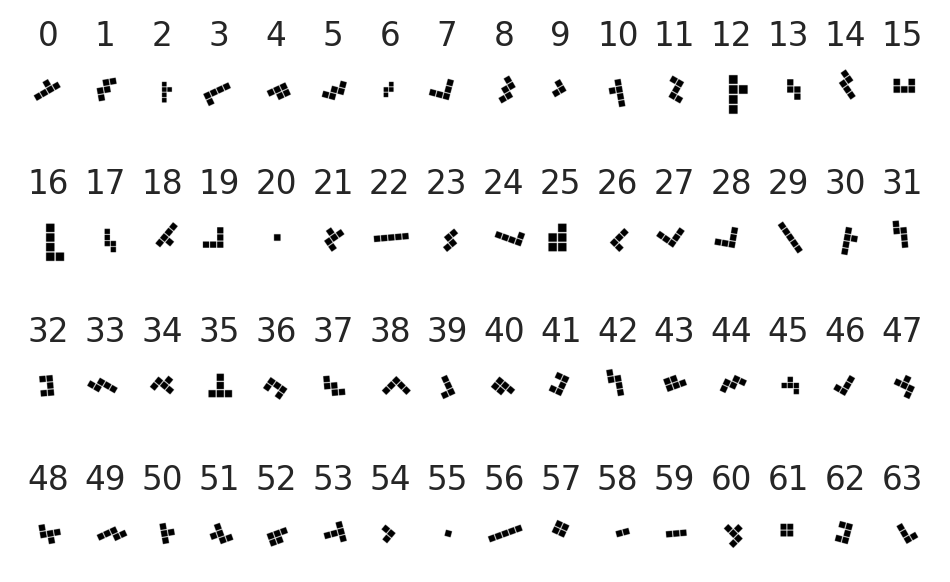

In [162]:
n = 64
fig = display_images(x_val[0:n], rows=4, cols=16, dpi=196, labels=range(n))

# Defining the $\beta\text{-VAE}$ Model


## The model contains the following components:

<h3>
<ol>
    <li> Preprocessor </li>
    <li> Encoder </li>
    <li> Latent Vector Sampler </li>
    <li> Decoder </li>
    <li> Loss Function (Reconstruction Loss + KL-Divergence) </li>
</ol>

    Note: Our loss function encourages a normally distributed prior $p(z)$ and a Gaussian posterior approximation $q(z|x)$.
    
</h3>

In [163]:
class Preprocessor(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__(name="preprocessor")

    # layers
    self.rescale = tf.keras.layers.Rescaling(scale=1.0/255.0, name="proprocessor/rescale")

  def call(self, inputs):
    x = self.rescale(inputs)
    return x

In [164]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, latent_dim):
    super().__init__(name="encoder")
    
    self.latent_dim = latent_dim
    
    # layers
    self.conv1 = tf.keras.layers.Conv2D(
      filters=64, 
      kernel_size=2, 
      strides=(1, 1), 
      padding='same', 
      activation='relu', 
      name='encoder/conv1')
    self.maxpool1 = tf.keras.layers.MaxPool2D(name='encoder/maxpool1')
    self.conv2 = tf.keras.layers.Conv2D(
      filters=32, 
      kernel_size=3, 
      strides=(1, 1), 
      padding='same', 
      activation='relu', 
      name='encoder/conv2')
    self.maxpool2 = tf.keras.layers.MaxPool2D(name='encoder/maxpool2')
    self.conv3 = tf.keras.layers.Conv2D(
      filters=32, 
      kernel_size=4, 
      strides=(1, 1), 
      padding='same', 
      activation='relu', 
      name='encoder/conv3')
    self.maxpool3 = tf.keras.layers.MaxPool2D(name='encoder/maxpool3')
    self.flatten = tf.keras.layers.Flatten(name='encoder/flatten')        
    self.logvar = tf.keras.layers.Dense(latent_dim, name='encoder/logvar')
    self.mu = tf.keras.layers.Dense(latent_dim, name='encoder/mu')
    self.sigma = tf.keras.layers.Lambda(lambda t: tf.keras.backend.exp(.5*t), name='encoder/sigma')
      
  def call(self, inputs):
    x = self.conv1(inputs)
    x = self.maxpool1(x)
    x = self.conv2(x)
    x = self.maxpool2(x)
    x = self.conv3(x)
    x = self.maxpool3(x)
    x = self.flatten(x)   
    return self.mu(x), self.logvar(x), self.sigma(self.logvar(x))

In [165]:
class Sampler(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__(name="sampler")
        
    def call(self, inputs):
        mu, sigma = inputs
        
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        
        # Gaussian noise
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        
        return mu + sigma * epsilon

In [166]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__(name="decoder")
        
        # layers
        self.dense1 = tf.keras.layers.Dense(units=8*8*64, activation=tf.nn.relu, name='decoder/dense1')
        self.reshape1 = tf.keras.layers.Reshape(target_shape=(8, 8, 64), name='decoder/reshape1')
        self.trans_conv1 = tf.keras.layers.Conv2DTranspose(
          filters=64,
          kernel_size=2,
          strides=(2, 2),
          padding='same',
          activation='relu',
          name='decoder/deconv1')
        self.trans_conv2 = tf.keras.layers.Conv2DTranspose(
          filters=32,
          kernel_size=2,
          strides=(2, 2),
          padding='same',
          activation='relu',
          name='decoder/deconv2')
        self.trans_conv3 = tf.keras.layers.Conv2DTranspose(
          filters=16,
          kernel_size=2,
          strides=(2, 2),
          padding='same',
          activation='relu',
          name='decoder/deconv3')
        self.trans_conv4 = tf.keras.layers.Conv2DTranspose(
          filters=8,
          kernel_size=2,
          strides=(2, 2),
          padding='same',
          activation='relu',
          name='decoder/deconv4')
        self.trans_conv5 = tf.keras.layers.Conv2DTranspose(
          filters=1,
          kernel_size=2,
          strides=(1, 1),
          padding='same',
          activation='sigmoid',
          name='decoder/deconv5')
        
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.reshape1(x)
        x = self.trans_conv1(x)
        x = self.trans_conv2(x)
        x = self.trans_conv3(x) 
        x = self.trans_conv4(x)
        return self.trans_conv5(x) 

In [167]:
preprocessor = Preprocessor()
encoder = Encoder(latent_dim=LATENT_DIM)
sampler = Sampler()
decoder = Decoder()

inputs = tf.keras.layers.Input(shape=INPUT_SHAPE, name="input")
x = preprocessor(inputs)
mu, logvar, sigma = encoder(x)
z = sampler((mu, sigma))
x_recon = decoder(z) 

# VAE Loss Function
<h2>
$
\begin{align}
\DeclareMathOperator{\ExpectedVal}{\mathbf{E}}
\DeclareMathOperator{\log}{\operatorname{log}}
\mathcal{L}(\theta, \phi; \mathbf{x}^{(i)}) = -D_{KL}(q_\phi(\mathbf{z} \vert \mathbf{x}^{(i)}) \| p_\theta(\mathbf{z})) + \ExpectedVal_{q_\phi(\mathbf{z}\vert\mathbf{x^{(i)}})}\big[\log p_\theta(\mathbf{x}^{(i)}\vert \mathbf{z})\big],
\end{align}
$ 
<br><br>
where $D_{KL}$ is the KL-divergence.
<br><br><br><br>
If we assume that $p_\theta(\mathbf{z}) = \mathcal{N}(0, 1) \text{ and } q_\phi(\mathbf{z}\vert \mathbf{x}^{(i)})$ is Gaussian, then the KL-divergence can be integrated analytically and has the value
$    
\begin{align}
\DeclareMathOperator{\log}{\operatorname{log}}
D_{KL}(q_\phi(\mathbf{z} \vert \mathbf{x}^{(i)}) \| p_\theta(\mathbf{z}) = -\frac{1}{2}\sum_{j=1}^J(1+\log((\sigma_j)^2) - (\mu_j)^2 - (\sigma_j)^2),
\end{align}
$
<br>
where $J$ is the dimensionality of the latent vector $z$.
</h2>

In [168]:
# Custom loss layer for reconstruction
class ReconstructionLoss(tf.keras.layers.Layer):
    def __init__(self):
      super(ReconstructionLoss, self).__init__(name="recon_loss")
      self.is_placeholder = True

    def call(self, inputs):
        x = inputs[0]
        x_recon = inputs[1]
        
        recon_loss = tf.keras.backend.sum(tf.keras.backend.binary_crossentropy(x, x_recon), axis=(1,2))
        recon_loss = tf.keras.backend.mean(recon_loss)
        
        self.add_loss(recon_loss, inputs=inputs)
        
        return recon_loss

# Custom loss layer for kl-loss
class KLLoss(tf.keras.layers.Layer):
    def __init__(self, beta=1.0):
      super(KLLoss, self).__init__(name="kl_loss")
      self.is_placeholder = True
              
      self.beta = beta

    def call(self, inputs):
        mu = inputs[0]
        logvar = inputs[1]
        
        # KL Divergence for Gaussian Distributions (see Kingma and Welling, 2014, p.11)
        # --> Assumes that the prior p(z) is normal and the posterior approximation q(z|x) is Gaussian
        kl_loss = -0.5 * self.beta * tf.keras.backend.sum(
            1.0 + logvar - tf.keras.backend.square(mu) - tf.keras.backend.exp(logvar), axis=-1)
        kl_loss = tf.keras.backend.mean(kl_loss)
        
        self.add_loss(kl_loss, inputs=inputs)
        
        return kl_loss

recon_loss = ReconstructionLoss()([x, x_recon])
kl_loss = KLLoss(beta=BETA)([mu, logvar])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model = tf.keras.Model(inputs=inputs, outputs = [x_recon, recon_loss, kl_loss])
model.compile(optimizer=optimizer, loss=None)

In [169]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
preprocessor (Preprocessor)     (None, 128, 128, 1)  0           input[0][0]                      
__________________________________________________________________________________________________
encoder (Encoder)               ((None, 64), (None,  1083904     preprocessor[0][0]               
__________________________________________________________________________________________________
sampler (Sampler)               (None, 64)           0           encoder[0][0]                    
                                                                 encoder[0][2]              

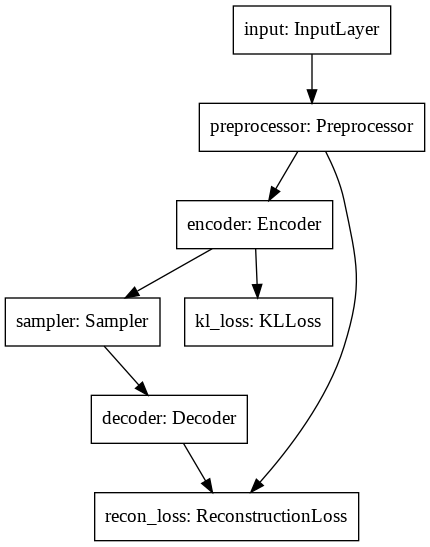

In [170]:
tf.keras.utils.plot_model(model)

## Visualize Reconstruction of Sampled Images *PRIOR TO TRAINING*.

### this should look like random noise (if not loading weights from a saved model)

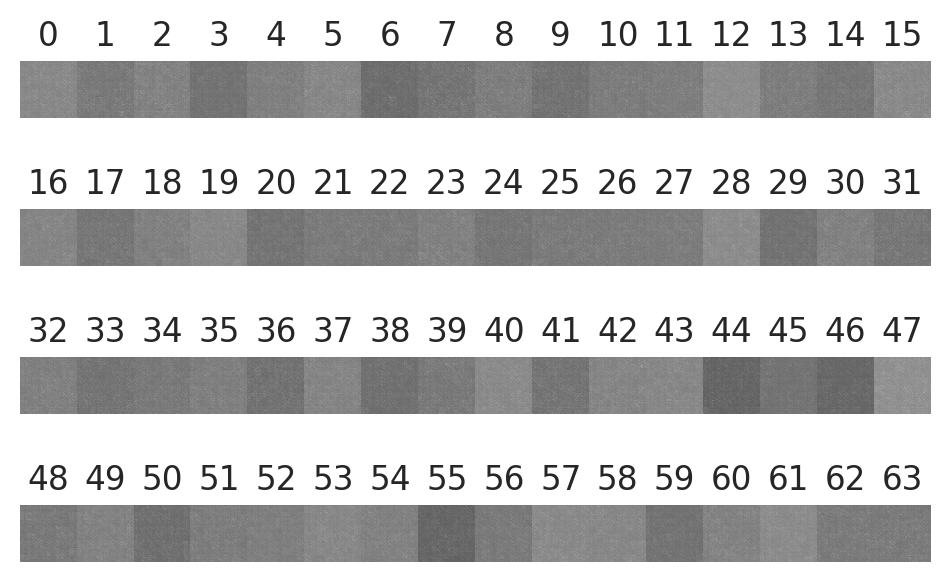

In [172]:
n = 64

# visualize generation before training
if TRAINING:
    images = x_val[0:n]

    xs, _, _ = model(images)  # reconstructed images

    display_images(images=xs[0:n], rows=4, cols=16, dpi=196, labels=range(n))

## Train The Model and Display Metrics For Model Performance on **Training** and **Validation** Data Sets

Epoch 1/500
54/54 [==============================] - 7s 91ms/step - loss: 5262.5776 - val_loss: 2070.4875
Epoch 2/500
54/54 [==============================] - 4s 77ms/step - loss: 1932.7169 - val_loss: 1706.8761
Epoch 3/500
54/54 [==============================] - 4s 73ms/step - loss: 1542.1171 - val_loss: 1401.7666
Epoch 4/500
54/54 [==============================] - 4s 75ms/step - loss: 1323.3171 - val_loss: 1228.6083
Epoch 5/500
54/54 [==============================] - 4s 75ms/step - loss: 1188.0630 - val_loss: 1124.4930
Epoch 6/500
54/54 [==============================] - 4s 74ms/step - loss: 1117.7184 - val_loss: 1071.2550
Epoch 7/500
54/54 [==============================] - 4s 74ms/step - loss: 1075.5854 - val_loss: 1040.0100
Epoch 8/500
54/54 [==============================] - 4s 74ms/step - loss: 1037.2391 - val_loss: 1012.0842
Epoch 9/500
54/54 [==============================] - 4s 74ms/step - loss: 1010.4515 - val_loss: 975.9193
Epoch 10/500
54/54 [===========================

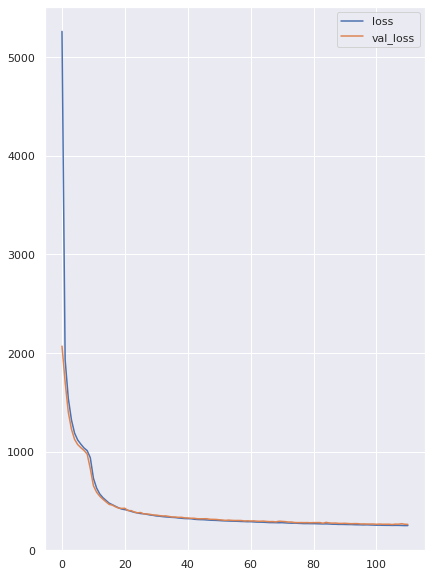

In [173]:
tf.autograph.set_verbosity(10)
if TRAINING:
    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    history = model.fit(
        train_ds, 
        callbacks=[early_stop_callback],              
        epochs=MAX_EPOCHS, 
        validation_data=val_ds,
    )
    
    plot_history(history, metrics=[('loss', 'val_loss')])

In [174]:
if SAVING_WEIGHTS:
    try:
        model.save_weights(SAVE_PATH, save_format='tf')
    except Exception as e:
        print(e)
        
elif LOADING_WEIGHTS:
    try:
        model.load_weights(SAVE_PATH)
    except Exception as e:
        print(e)

## Visualize Reconstruction of Sampled Images *AFTER TRAINING*.

### note: these are images from the **VALIDATION** data set: the auto-encoder was NOT trained on these!

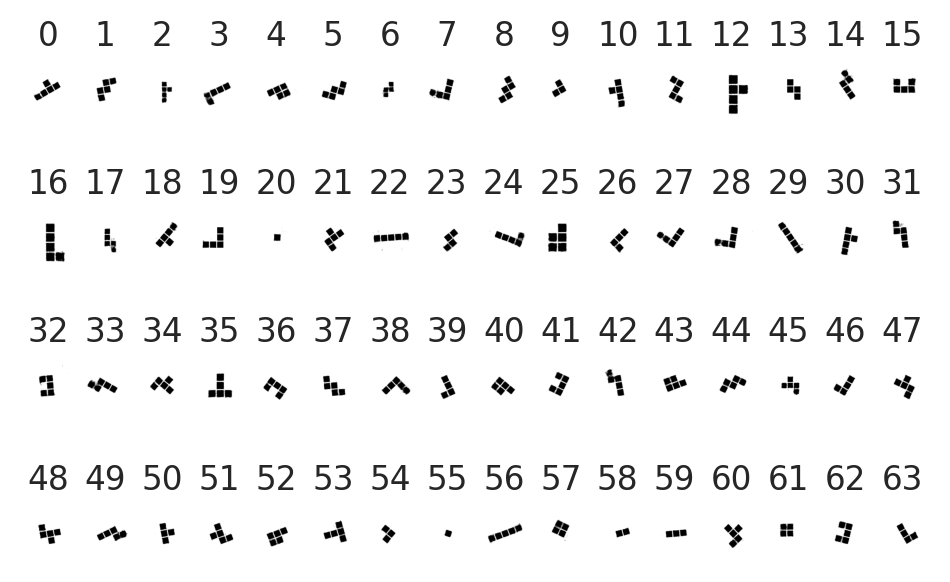

In [178]:
n = 64

# visualize generation after training
xs_recon, _, _ = model(x_val[0:n]) # latent vectors

fig = display_images(xs_recon[0:n], rows=4, cols=16, dpi=196, labels=range(n))

# Comparison between Original Images and Reconstructions

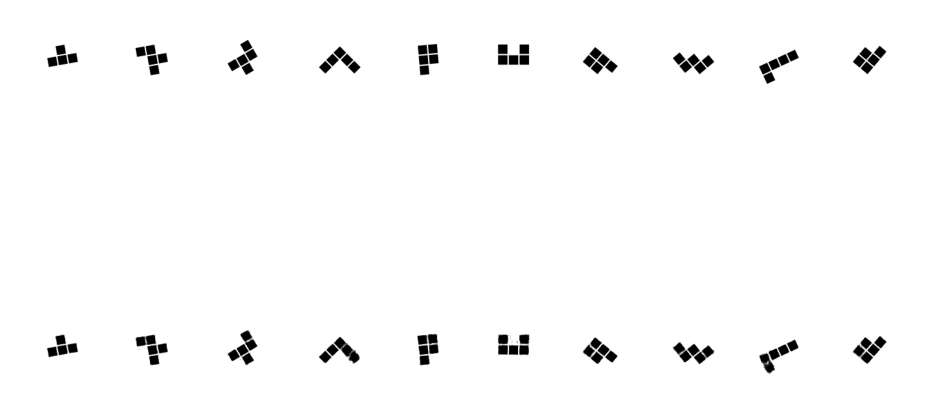

In [181]:
images = x_val

xs = preprocessor(images)
mu, _, sigma = encoder(xs)
zs = sampler((mu, sigma))
xs_recon = decoder(zs)

np.random.seed(RANDOM_SEED)
idxs = np.random.uniform(0, len(images), size=10).astype(int)
imgs = np.concatenate([xs.numpy()[idxs], xs_recon.numpy()[idxs]])

fig = display_images(imgs, rows=2, cols=len(idxs), wspace=0.1, dpi=192)
# fig.savefig('recon.svg', format='svg', dpi=500)

<hr>
<h1> Cosine Similarity Over Learned Gaussians </h1>
<h2>
$
\begin{align}
\text{cosine similarity}(\vec{u}, \vec{v}) \equiv \frac{\vec{u} \cdot \vec{v}}{\| u \| \| v \|}
\end{align}
$
</h2>

In [182]:
from sklearn.metrics.pairwise import cosine_similarity

## Illustration of Cosine Similarity Distance Metric 

In [183]:
# Examples for cosine similarity distance metric

# identical vectors
u = np.random.rand(100)
v = u

cosine_similarity([u, v])

array([[1., 1.],
       [1., 1.]])

In [184]:
# orthogonal vectors
u = np.random.rand(100)
v = np.random.rand(100)

# apply Gram-Schmidt to make v orthogonal to u
v -= v.dot(u) * u / np.linalg.norm(u)**2

cosine_similarity([u, v])

array([[1.00000000e+00, 2.66356677e-16],
       [2.66356677e-16, 1.00000000e+00]])

In [185]:
# opposite vectors
u = np.random.rand(100)
v = -u

cosine_similarity([u, v])

array([[ 1., -1.],
       [-1.,  1.]])

## Most Similar Exemplars (based on cosine similarity)

## Randomly select training images from each class

In [371]:
n_classes = np.unique(labels).shape[0]
n_samples_per_class = 4

In [372]:
# randomly sample an equal number of images from each class
np.random.seed(RANDOM_SEED)
imgs = np.concatenate(
    [x_train[np.random.choice(np.reshape(np.argwhere(y_train==cls), -1), 
                             n_samples_per_class, replace=False)]
                       for cls in range(n_classes)], axis=0)

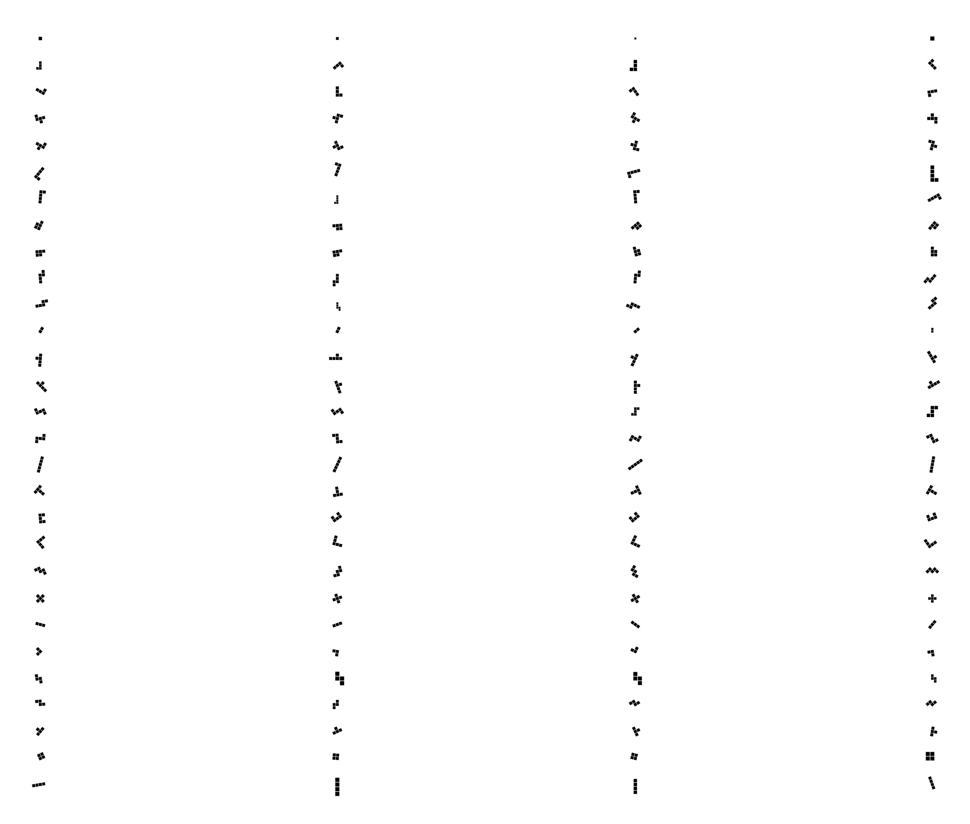

In [373]:
fig = display_images(imgs, rows=n_classes, cols=n_samples_per_class, dpi=256)

## Calculate Cosine Similarity Distance Matrix Using Means ($\vec{\mu}$) Of Latent Prob. Distributions

In [207]:
x = preprocessor(imgs)
mu, _, sigma = encoder(x)
zs = sampler((mu, sigma))
xs = decoder(zs)

In [208]:
dist_matrix = cosine_similarity(mu)
dist_matrix = np.round(dist_matrix, decimals=4)

## Apply A Sigmoidal Activation Function (denoted $\alpha_c$) To Cosine Similarities (denoted $\delta$)

<h3>
Ideally, we want this activation function to have the following properties:

1. if $\delta(x,y)$ is close to 1.0 then $\delta(x,y) \approx \alpha_c(\delta(x,y))$
2. if $\delta(x,y)$ < instantiation threshold then $\alpha_c(\delta(x,y)$ should be dampened towards 0.0
                                                                         
</h3>


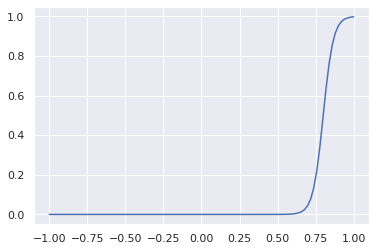

In [366]:
def curr_activation(x, a, b):
    return 1.0 / (1.0 + np.exp(-a*x+b))

# activation function parameters (a = 1.0, b = 0.0 gives standard logistic function)
a = 30.0 # steepness of curve
b = a * 0.8 # horizontal shift

x = np.linspace(-1.0, 1.0, 100)
y = curr_activation(x, a, b) 
plt.plot(x,y)

In [367]:
using_activation = True

# Passing the cosine similarity through a sigmoidal activation function
act_matrix = np.copy(dist_matrix)

if using_activation:
    act_matrix = curr_activation(act_matrix, a, b)
    
act_matrix = np.round(act_matrix, decimals=4)

## Create a Heatmap Showing $\alpha_c$

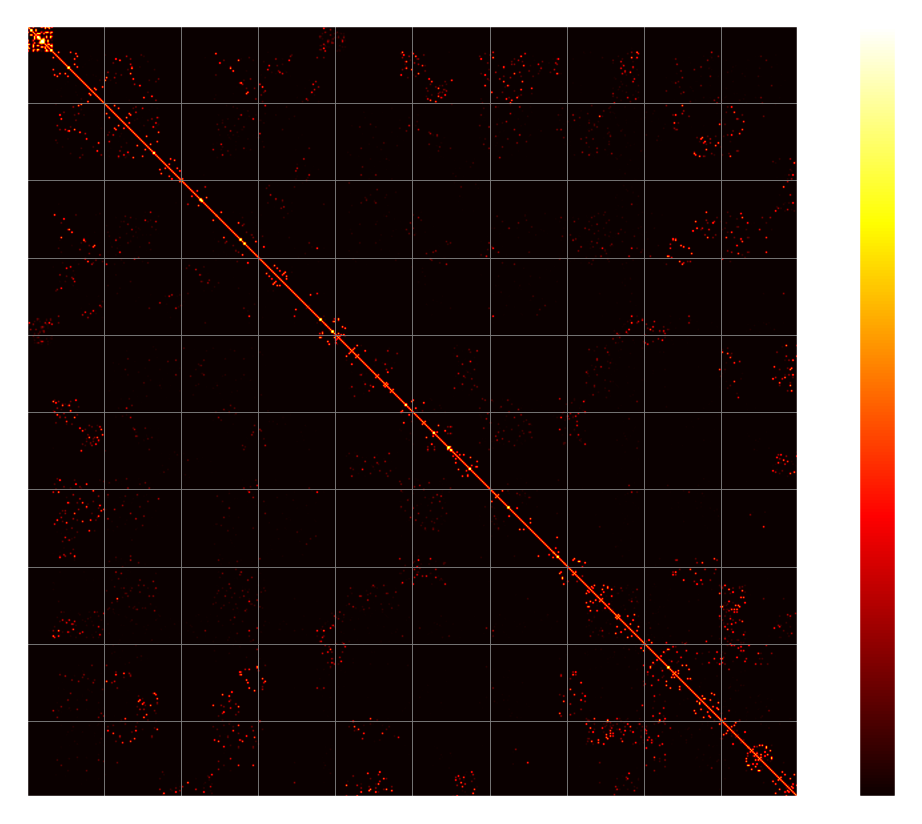

In [368]:
SMALL_SIZE = 10
MEDIUM_SIZE = 11
BIGGER_SIZE = 12

plt.rcParams['font.family'] ='Times New Roman'

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels

fig = plt.figure(dpi=256)
ax = fig.gca()
im = ax.imshow(act_matrix, cmap='hot', interpolation='gaussian')
ax.set_xticks(np.arange(0,len(imgs)+1,int((len(imgs))/10)))
ax.set_yticks(np.arange(0,len(imgs)+1,int((len(imgs))/10)))

ax.tick_params(axis='both', which='both', length=0)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(which='major', color='gray', linestyle='-', linewidth=0.25)

cb = plt.colorbar(im)
cb.set_ticks([])
    
plt.show()

# uncomment to export figure
# fig.savefig('curr_act_heatmap.svg', format='svg', dpi=300)

## Find the Most (or Least) Similar Images for a Given Input

In [369]:
def get_n_similar(images, index, act_matrix, n, reversed=False):
    
    # ranks images by distance from reference image (descending order)
    ranked_indices_with_dist = np.array(
        sorted(
            np.array(list(enumerate(act_matrix[index]))), # matrix of image indices and their corresponding current activations
            key=lambda x: x[1], # key on activation
            reverse=not reversed)) # if reversed then least similar appear first in result
    
    return ranked_indices_with_dist[0:n,:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


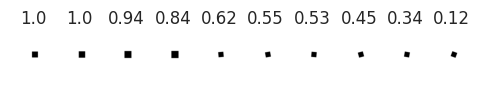

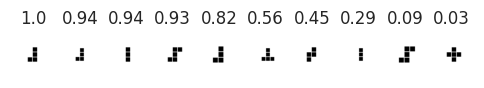

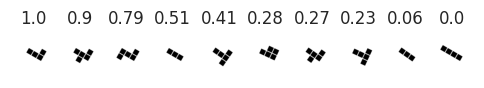

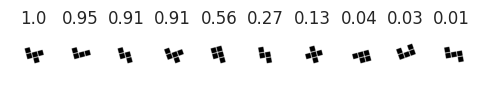

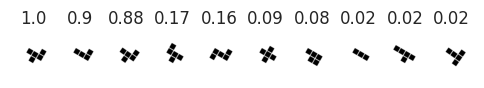

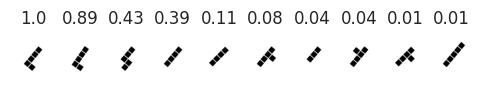

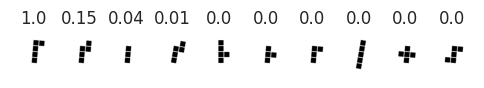

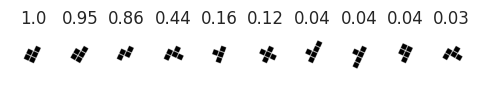

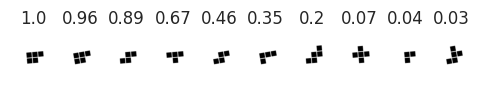

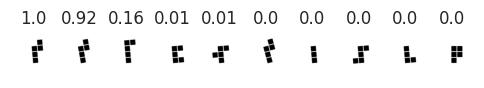

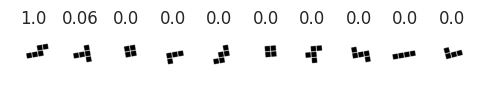

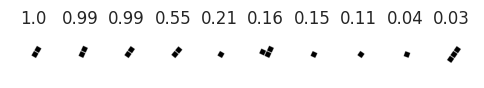

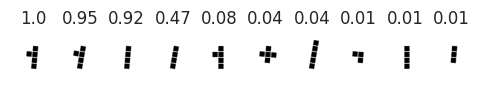

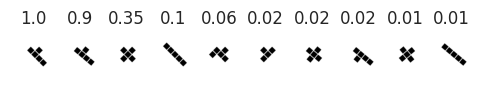

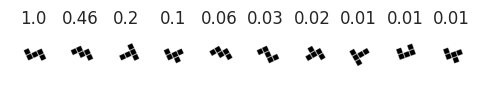

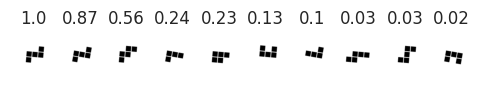

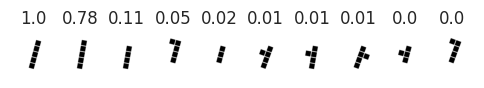

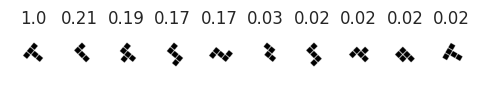

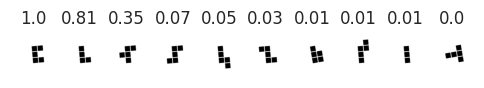

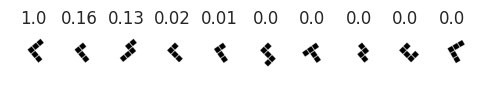

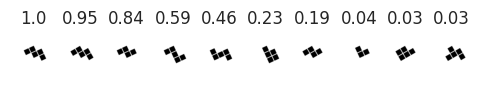

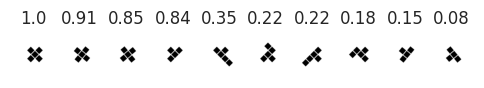

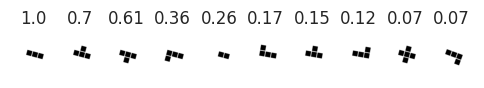

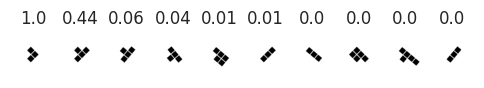

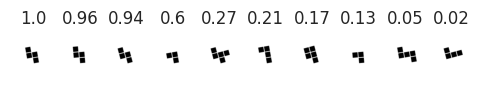

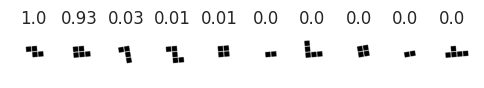

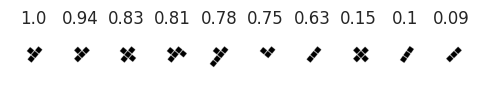

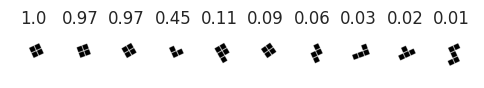

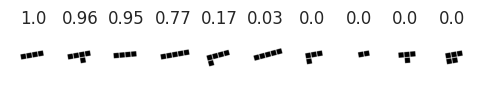

In [370]:
n = 10
ref_ndxs = range(0,n_samples_per_class*n_classes, n_samples_per_class)

curr_class = 0
for ndx in ref_ndxs:
    sims = get_n_similar(imgs, ndx, act_matrix, n)
    
    indices = sims[:,0].astype(int)
    dists = list(map(str, np.round(sims[:,1], decimals=2)))
    
    fig = display_images(imgs[indices], rows=1, cols=len(indices), labels=dists, dpi=100)
    
    # uncomment to export figure
    # fig.savefig('{cls}_distance_from_ref_image.svg'.format(cls=curr_class), format='svg', dpi=100)
    
    curr_class += 1

## K-nearest neighbors (KNN) using latent similarities and activation function

In [350]:
n_exemplars = dist_matrix.shape[0]

conf_matrix = np.zeros(shape=(n_classes + 1, n_classes + 1))
k = 3
threhold = 0.9 # instantiation threshold

UNK_VALUE = np.array([[n_exemplars + 1, 0.0]])

for ndx in range(n_exemplars):
    
    # k most similar (removing "best match", which will be a self-reference)
    k_similar_set = get_n_similar(imgs, ndx, act_matrix, k + 1)[1:]
    
    # remove examples below threshold
    k_similar_set = k_similar_set[k_similar_set[:,1] > threhold]
    
    # if all examples below threshold add UNKNOWN index
    if len(k_similar_set) == 0:
        k_similar_set = UNK_VALUE
               
    # calculate the object classes from indicies for most (cosine) similar
    obj_classes = k_similar_set[:,0].astype(int) // n_samples_per_class
    
    # determine best object class as object class with max number of members in most_similar_set
    predicted_class = np.argmax(np.bincount(obj_classes))
    actual_class = ndx // n_samples_per_class 
                
    conf_matrix[actual_class,predicted_class] += 1
        
print('overall accuracy: ', sum(np.diag(conf_matrix[0:10, 0:10]))/ np.sum(conf_matrix[0:10, 0:10]))

overall accuracy:  0.8588235294117647


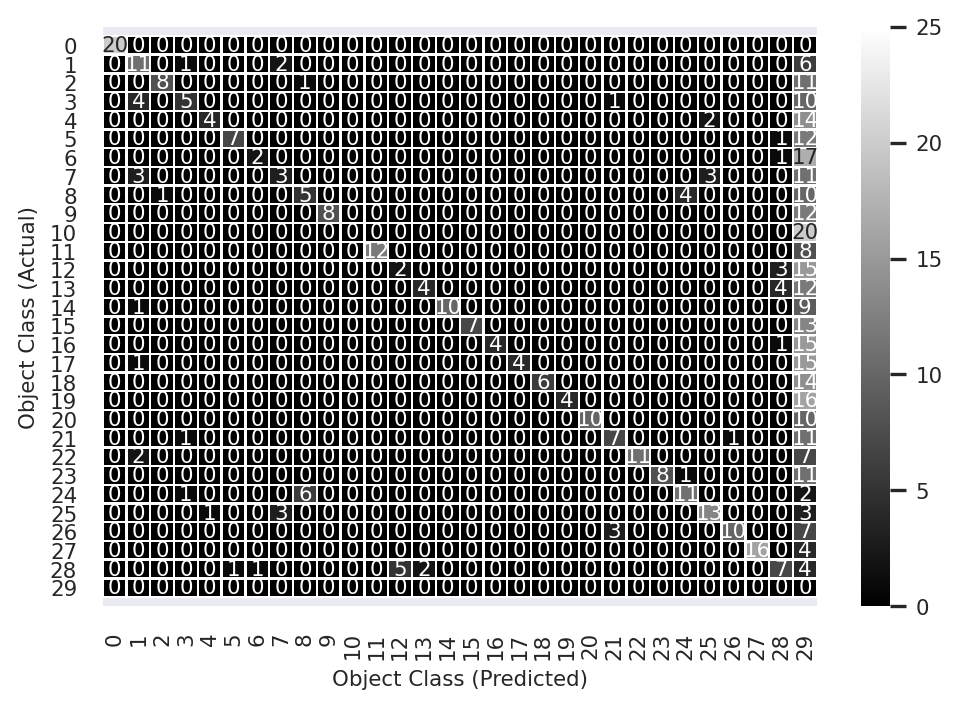

In [351]:
SMALL_SIZE = 8
MEDIUM_SIZE = 9
BIGGER_SIZE = 10

plt.rcParams['font.family'] ='Times New Roman'

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels

fig = plt.figure(dpi=192)

ax = sns.heatmap(conf_matrix, annot=True, vmax=25, linewidths=.5, cmap="gist_gray", xticklabels=True, yticklabels=True)
ax.set_xlabel("Object Class (Predicted)")
ax.set_ylabel("Object Class (Actual)")

# fix issue with plot cutting off top and bottom of image
b, t = ax.get_ylim()
b += 0.5
t -= 0.5
ax.set_ylim(b,t)

plt.show()
# fig.savefig('knn_confmatrix.svg', format='svg')

## Comparing (Cosine) Similarity Between $\vec{\mu}$ Of Images and Their Reconstructions

In [352]:
xs = preprocess(imgs)
mus, _, sigmas = encoder(xs)
zs = sampler((mus, sigmas))
xs_recon = decoder(zs)

In [353]:
recon_mus, _, recon_sigma = encoder(xs_recon)

## For a Single Instance...

In [354]:
def display_image_and_recon(ndx):
    orig = imgs[ndx]
    orig_mu = np.expand_dims(mus[ndx], 0)

    recon = xs_recon[ndx]
    recon_mu = np.expand_dims(recon_mus[ndx], 0)

    fig = display_images([orig, recon], rows=1, cols=2, dpi=90, labels=['original', 'reconstruction'])

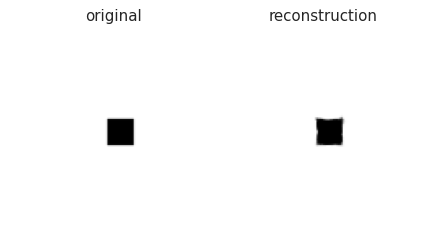

In [355]:
display_image_and_recon(ndx=0)

## Cosine Similarity Matrix Between $\vec{\mu}$ for Images and Their Reconstructions

In [356]:
recon_dist_matrix = cosine_similarity(recon_mus, mus)

### Most and Least Similar (Between Images and Their Reconstructions)

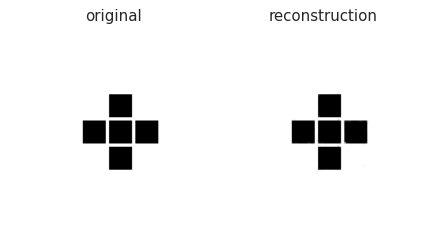

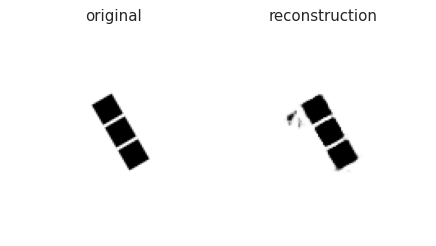

In [357]:
ndx_least_similar, ndx_most_similar = np.argmin(np.diag(recon_dist_matrix)), np.argmax(np.diag(recon_dist_matrix))

display_image_and_recon(ndx_most_similar)
display_image_and_recon(ndx_least_similar)

## Activation Heatmap Between Reconstructions and Original Images

In [358]:
# Passing the cosine similarity through a sigmoidal activation function
recon_act_matrix = np.copy(dist_matrix)

if using_activation:
    recon_act_matrix = curr_activation(act_matrix, a, b)
    
recon_act_matrix = np.round(recon_act_matrix, decimals=4)

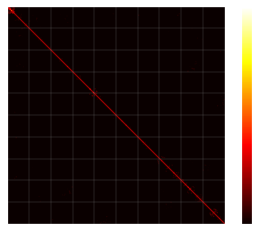

In [359]:
SMALL_SIZE = 10
MEDIUM_SIZE = 11
BIGGER_SIZE = 12

plt.rcParams['font.family'] ='Times New Roman'

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels

fig = plt.figure()
ax = fig.gca()
im = ax.imshow(recon_act_matrix, cmap='hot', interpolation='gaussian')
ax.set_xticks(np.arange(0,len(imgs)+1,int((len(imgs))/10)))
ax.set_yticks(np.arange(0,len(imgs)+1,int((len(imgs))/10)))

ax.tick_params(axis='both', which='both', length=0)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(which='major', color='gray', linestyle='-', linewidth=0.25)

cb = plt.colorbar(im)
cb.set_ticks([])
    
plt.show()
# fig.savefig('recon_curr_act_heatmap.svg', format='svg', dpi=300)

In [298]:
n_exemplars = recon_act_matrix.shape[0]

conf_matrix = np.zeros(shape=(n_classes + 1, n_classes + 1))
k = 5
act_threhold = 0.0

UNK_VALUE = np.array([[n_exemplars + 1, 0.0]])

for ndx in range(n_exemplars):
    
    # k most similar (removing "best match", which will be a self-reference)
    k_similar_set = get_n_similar(imgs, ndx, recon_act_matrix, k + 1)[1:]
    
    # remove examples below threshold
    k_similar_set = k_similar_set[k_similar_set[:,1] > act_threhold]
    
    # if all examples below threshold add UNKNOWN index
    if len(k_similar_set) == 0:
        k_similar_set = UNK_VALUE
               
    # calculate the object classes from indicies for most (cosine) similar
    obj_classes = k_similar_set[:,0].astype(int) // n_samples_per_class
    
    # determine best object class as object class with max number of members in most_similar_set
    predicted_class = np.argmax(np.bincount(obj_classes))
    actual_class = ndx // n_samples_per_class 
                
    conf_matrix[actual_class,predicted_class] += 1
        
print('overall accuracy: ', sum(np.diag(conf_matrix[0:10, 0:10]))/ np.sum(conf_matrix[0:10, 0:10]))

overall accuracy:  0.40145985401459855


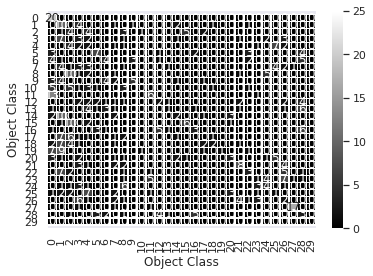

In [299]:
SMALL_SIZE = 10
MEDIUM_SIZE = 11
BIGGER_SIZE = 12

plt.rcParams['font.family'] ='Times New Roman'

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels

fig = plt.figure()

ax = sns.heatmap(conf_matrix, annot=True, vmax=25, linewidths=.5, cmap="gist_gray", xticklabels=True, yticklabels=True)
ax.set_xlabel("Object Class")
ax.set_ylabel("Object Class")

# fix issue with plot cutting off top and bottom of image
b, t = ax.get_ylim()
b += 0.5
t -= 0.5
ax.set_ylim(b,t)

plt.show()

# uncomment to export image
# fig.savefig('knn_confmatrix.svg', format='svg')

# Rotation Analysis

In [79]:
ds_options = {
    'directory': 'data/images/24',
    'labels': None,
    'color_mode': "grayscale",
    'batch_size': 1,
    'image_size': INPUT_SHAPE[0:2],
    'shuffle': False,
}

poly_24_ds = tf.keras.utils.image_dataset_from_directory(**ds_options)

Found 45 files belonging to 1 classes.


In [80]:
# there must be a better way to do this...
poly_24_imgs = None

for img in list(poly_24_ds.as_numpy_iterator()):
  poly_24_imgs = img if poly_24_imgs is None else np.append(poly_24_imgs, img, axis=0)

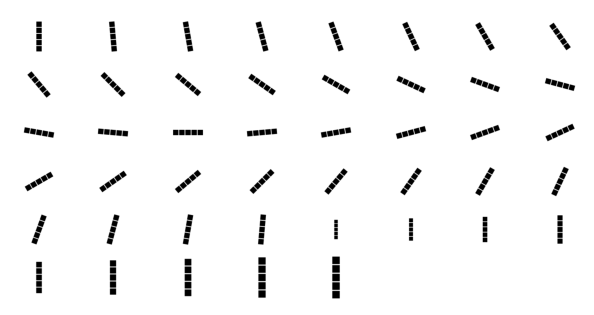

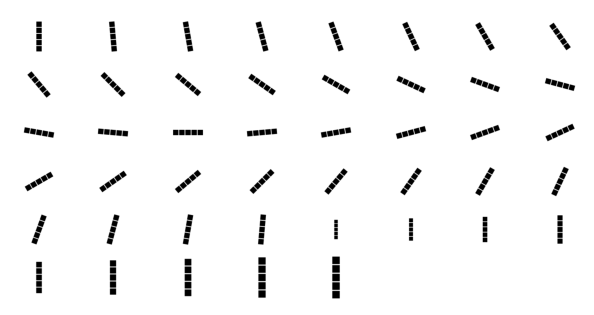

In [81]:
fig = display_images(poly_24_imgs, 8, 8)